# Import required library

In [1]:
import cv2
import os
import glob
import random
import numpy as np
from tqdm import tqdm

from patchify import patchify
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

2021-11-26 14:19:56.940740: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Set the environment variable

In [2]:
WORKING_DIR = r'data'
NUMBER_OF_IMAGES = 2000 #You can put maximum of 5598 i.e. equal to `len(TRAIN_IMG)`
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
PATCH_SIZE = 256
IMG_CHANNEL = 3
IOU_THRESHOLD = 0.7

# Patches per image
NUMBER_OF_PATCHES_PER_IMG = int((IMG_WIDTH / PATCH_SIZE) * (IMG_WIDTH / PATCH_SIZE))
TOTAL_PATCHES = NUMBER_OF_IMAGES * NUMBER_OF_PATCHES_PER_IMG

# Preprocessing the data

The dataset is really huge. I don't need this much data for testing purpose. I am going to use only the 2000 dataset for this purpose.

In [3]:
TRAIN_IMG = sorted(glob.glob(WORKING_DIR + '/images/*.png'))
TRAIN_MASK = sorted(glob.glob(WORKING_DIR + '/targets/*.png'))

In [4]:
image_dataset = []
for i, img in tqdm(enumerate(TRAIN_IMG)):
    if i== NUMBER_OF_IMAGES:
        break
    img_before_patch = cv2.imread(img) / 255
    img_patches = patchify(img_before_patch, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
    img_patches = img_patches.reshape((NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE, 3))
    image_dataset.append(img_patches)

2000it [01:06, 30.17it/s]


In [5]:
image_dataset = np.array(image_dataset).reshape((NUMBER_OF_IMAGES * NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE, IMG_CHANNEL))
image_dataset.shape

(32000, 256, 256, 3)

In [6]:
mask_dataset = []
for i, mask in tqdm(enumerate(TRAIN_MASK)):
    if i == NUMBER_OF_IMAGES:
        break
    mask_before_patch = cv2.imread(mask)[:, :, 0]
    mask_patches = patchify(mask_before_patch, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE)
    mask_patches = mask_patches.reshape((NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE))
    mask_dataset.append(mask_patches)

2000it [00:09, 213.11it/s]


In [7]:
mask_dataset = np.array(mask_dataset).reshape((NUMBER_OF_IMAGES * NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE, 1))
mask_dataset.shape

(32000, 256, 256, 1)

In [8]:
print(image_dataset.shape, mask_dataset.shape)

(32000, 256, 256, 3) (32000, 256, 256, 1)


In [9]:
# All the data that has more than 1 is building
# np.where(condition, true_statement, false_statement)
mask_dataset = np.where(mask_dataset > 0, 1, 0)

In [10]:
zero_indices = []
for i, mask in tqdm(enumerate(mask_dataset)):
    if(np.all(mask==0)):
        zero_indices.append(i)

32000it [00:01, 19168.39it/s]


In [11]:
image_dataset = np.delete(image_dataset, zero_indices, axis=0)
mask_dataset = np.delete(mask_dataset, zero_indices, axis=0)

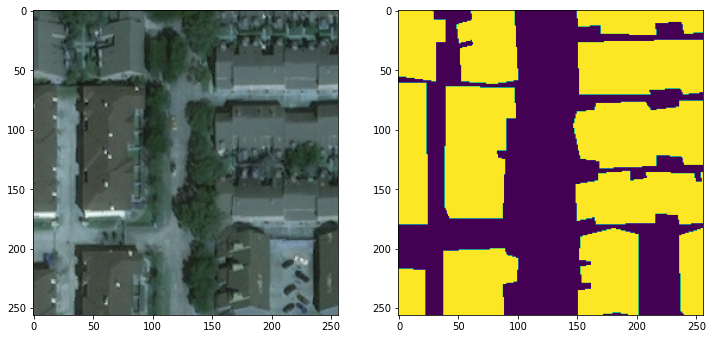

In [12]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.uint8(image_dataset[image_number] * 255))
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12948, 256, 256, 3) (3238, 256, 256, 3) (12948, 256, 256, 1) (3238, 256, 256, 1)


# Unet Model

In [15]:
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = unet_model(PATCH_SIZE, PATCH_SIZE, IMG_CHANNEL)
# model.summary()

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("model_output.h5", verbose=1, save_best_only=True)

callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
    ]

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)

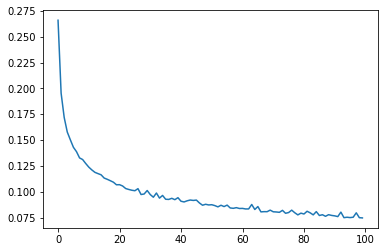

In [19]:
plt.plot(history.history['loss'])
plt.show()

# Result analysis

In [20]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [21]:
#Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 1.0


In [22]:
preds_train = model.predict(X_test, verbose=1)
preds_train_t = (preds_train > IOU_THRESHOLD).astype(np.uint8)

102/102 [==============================] - 3s 33ms/step


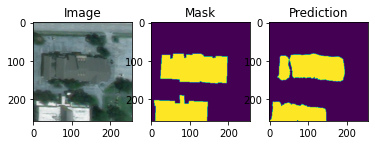

In [30]:
ix = random.randint(0, len(preds_train_t))

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.uint8(X_test[ix] * 255))
ax1.set_title("Image")
ax2.imshow(y_test[ix].astype(int))
ax2.set_title("Mask")
ax3.imshow(preds_train_t[ix].astype(int))
ax3.set_title("Prediction")
plt.show()